# Tensorflow MNIST Classifier demo

This notebook contains an end-to-end demostration of Dioptra that can be run on any modern laptop.
Please see the [example README](README.md) for instructions on how to prepare your environment for running this example.

## Initial Setup

### Setup the Python client and Login to the Dioptra deployment

To connect with the endpoint, we will use the Dioptra client included in the dioptra package
We connect using the client below.
It is necessary to login to the RESTAPI to be able to perform any functions. Here we create a user if it is not created already, and login with it.

In [1]:
from dioptra.client import connect_json_dioptra_client
from dioptra.client.base import StatusCodeError
from contextlib import suppress
from pprint import pprint

DIOPTRA_REST_API_ADDRESS = "http://localhost"
DIOPTRA_REST_API_USER = "dioptra-default-user"
DIOPTRA_REST_API_PASS = "dioptra-default-password"

client = connect_json_dioptra_client(DIOPTRA_REST_API_ADDRESS)

with suppress(StatusCodeError): client.users.create(DIOPTRA_REST_API_USER, email=f"{DIOPTRA_REST_API_USER}@localhost", password=DIOPTRA_REST_API_PASS)
client.auth.login(DIOPTRA_REST_API_USER, DIOPTRA_REST_API_PASS)

{'username': 'dioptra-default-user', 'status': 'Login successful'}

### Import libraries and define helper functions

Below we import the necessary Python modules so that all the code blocks will work as expected. These helper functions include things like waiting for jobs to finish, downloading artifacts, and displaying them in the notebook.

In [2]:
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import structlog
import time
import warnings

from IPython.display import display, clear_output
from pathlib import Path
from pprint import pprint
from tempfile import TemporaryDirectory
from typing import Any
from dioptra.client import select_files_in_directory


# Filter out warning messages
warnings.filterwarnings("ignore")
structlog.configure(
    wrapper_class=structlog.make_filtering_bound_logger(logging.ERROR),
)

def wait_for_job(job, quiet=False):
    n = 0
    while job['status'] not in ['finished', 'failed']:
        job = client.jobs.get_by_id(job['id'])
        time.sleep(1)
        if not quiet:
            clear_output(wait=True)
            display("Waiting for job to finish" + "." * (n % 3) )
        n += 1
    if not quiet:
        if job['status'] == 'finished':
            clear_output(wait=True)
            display(f'Job finished.')
        else:
            display("Job failed. Please see job logs for details.")
    return job

def find_artifact_by_name(artifact_name: str, job: dict[str, Any]) -> dict[str, Any]:
    for job_artifact in job["artifacts"]:
        artifact = client.artifacts.get_by_id(job_artifact["id"])
        if artifact_name in artifact["description"]:
            return {
                "id": artifact["id"],
                "snapshotId": artifact["snapshot"],
            }
    raise Exception("Could not retrieve artifact")

def load_image_from_artifact(artifact, path):
    with TemporaryDirectory() as t:
        local_path = client.artifacts.get_contents(artifact["id"], artifact_path=path, output_dir=t, file_stem="tmp.png")
        return plt.imread(local_path)

def get_metrics(job):
    return {m["name"]: m["value"] for m in client.jobs.get_metrics_by_id(job_id=job["id"])}

def display_sample_images(artifact, title=None):
    paths = [f["relativePath"] for f in client.artifacts.get_files(artifact["id"])]
    for idx, path in enumerate(paths[:9]):
        sample = load_image_from_artifact(artifact, paths[idx])
        plt.subplot(3, 3, idx+1)
        plt.imshow(sample, cmap="gray")
        if title is not None:
            plt.suptitle(title)
def display_training_stats(job):
    epochs = int(job["values"]["epochs"])
    metrics = get_metrics(jobs["train"])
    loss = client.jobs.get_metrics_snapshots_by_id(job_id=job["id"], metric_name="loss")
    accuracy = client.jobs.get_metrics_snapshots_by_id(job_id=job["id"], metric_name="categorical_accuracy")
    plt.plot([m["value"] for m in loss["data"]], color="green", label="val_loss")
    plt.plot([m["value"] for m in accuracy["data"]], color="blue", label="val_accuracy")
    plt.hlines(metrics["test_categorical_accuracy"], xmin=0, xmax=epochs-1, linestyles="dashed", color="blue", label="test_accuracy")
    plt.title(job["description"])
    plt.xlabel("epoch")
    plt.xticks(list(range(epochs)))
    plt.legend()

def display_metrics(metrics, metric: str):
    metrics = sorted(metrics.items())
    plt.bar([m[0] if len(m[0]) < 15 else m[0][:15] + "..." for m in metrics], [m[1][metric] for m in metrics])
    plt.xticks(rotation=45, fontsize=10)
    plt.title(metric)

### Setup dataset

We obtain a copy of MNIST using scripts/download_data.py.

Usage:

```bash
uv run download_data.py --data-dir ~/datasets/ download mnist
```

This assumes that during the initial container configuration, ~/datasets was used as the mounted volume directory for supplying datasets to /dioptra/data within the container. 

### Upload all the entrypoints in the src/ folder

In this step, we do several things:
  1. Upload all the plugins and entrypoints in the `extra/` folder.
  2. Register these plugins and entrypoints with the Dioptra RESTAPI for use in our experiment.
  3. Create a queue which represents the `tensorflow_cpu` container created as part of the Dioptra default installation.
  4. Register an experiment named `mnist_fgm`.
  5. Associate all of the entrypoints we created with the `mnist_fgm` experiment.

In [ ]:
EXPERIMENT_NAME = "mnist_fgm"
EXPERIMENT_DESC = "applying the fast gradient sign (FGM) attack to a classifier trained on MNIST"
QUEUE_NAME = "tensorflow_cpu"
QUEUE_DESC = "Tensorflow CPU Queue"
JOB_TIME_LIMIT = "1h"

# import from local filesystem

response = client.workflows.import_resources(group_id=1,
                                             source=select_files_in_directory("../extra/", recursive=True),
                                             config_path="dioptra_optic.toml",
                                             resolve_name_conflicts_strategy="fail",
                                            )
resources = response["resources"]

train_ep = resources["entrypoints"]["Train Keras Image Classifier"]
fgm_ep = resources["entrypoints"]["Evasion Attack: Fast Gradient Method"]
patch_gen_ep = resources["entrypoints"]["Evasion Attack: Adversarial Patch (Generate)"]
patch_apply_ep = resources["entrypoints"]["Evasion Attack: Adversarial Patch (Apply)"]
predict_ep = resources["entrypoints"]["Predict Keras Image Classifier"]
metrics_ep = resources["entrypoints"]["Evaluate Keras Image Classifier"]
defense_ep = resources["entrypoints"]["Defense: Preprocessing"]

entrypoints = [train_ep, fgm_ep, patch_gen_ep, patch_apply_ep, predict_ep, metrics_ep, defense_ep]

# create dictionaries for storing jobs, artifacts, and artifacts
jobs = {}
artifacts = {}
metrics = {}

In [4]:
with suppress(StatusCodeError): experiment = client.experiments.create(group_id=1, name=EXPERIMENT_NAME, description=EXPERIMENT_DESC)
experiment = client.experiments.get(search=f"name:'{EXPERIMENT_NAME}'")["data"][0]

with suppress(StatusCodeError): queue = client.queues.create(group_id=1, name=QUEUE_NAME, description=QUEUE_DESC)
queue = client.queues.get(search=f"name:'{QUEUE_NAME}'")["data"][0]

experiment_id = experiment['id']
queue_id = queue['id']

client.experiments.entrypoints.create(experiment_id=experiment_id, entrypoint_ids=entrypoints)

for entrypoint in entrypoints:
    client.entrypoints.queues.create(entrypoint_id=entrypoint, queue_ids=[queue_id])

# Experiment: Evaluate Attacks and Defenses on an Image Classifier

Now that everything is setup and registered in Dioptra, we can run a series of entrypoints and retrieve results.
We will train a small convolutional neural network on a handwritten digit dataset to identify the digits 0-9

### Train a new LeNet model on MNIST

The resulting model will be saved as an artifact for futher use.

In [5]:
jobs["train"] = client.experiments.jobs.create(
    experiment_id=experiment_id, 
    description=f"Train a LeNet model on the MNIST dataset.", 
    queue_id=queue_id,
    entrypoint_id=train_ep, 
    values={
        "dataset_name": "mnist",
        "model_name": "LeNet",
        "epochs": "3",
    }, 
    timeout=JOB_TIME_LIMIT,
)
jobs["train"] = wait_for_job(jobs["train"])
metrics["baseline"] = get_metrics(jobs["train"])
artifacts["data_sample"] = find_artifact_by_name("dataset_sample", jobs["train"])
artifacts["model"] = find_artifact_by_name("model", jobs["train"])

'Job finished.'

Let's look at a sample of the dataset:

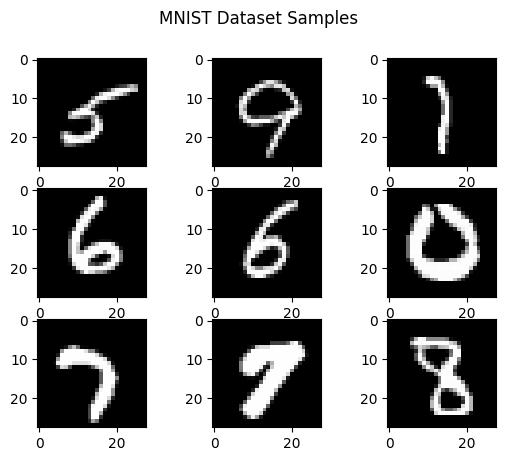

In [6]:
display_sample_images(artifacts["data_sample"], "MNIST Dataset Samples")

Now that the model training job is finished. Let's retrieve the metrics and plot them.

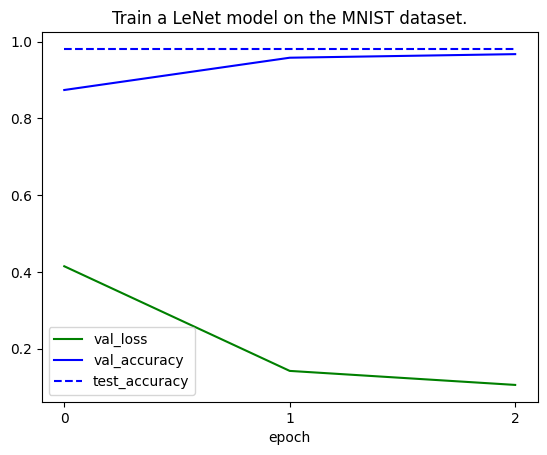

In [7]:
display_training_stats(jobs["train"])

### Generate adversarial examples using FGM attack

Next we want to understand if our model is vulnerable to an adversarial evasion attack. In evasion attacks, an adversary makes (minimal) pertubations to inference data to cause the model to misclassify the input (See [NIST AI 100-2 E2025](https://csrc.nist.gov/pubs/ai/100/2/e2025/final)). We will work with one of the earliest and simplest approaches to creating adversarial examples: the fast gradient sign method.

Note that here, we will be using the model we trained in the previous step.

In [8]:
jobs["fgm"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"Generate an adversarial dataset with the fast gradient method.",
    queue_id=queue_id,
    entrypoint_id=fgm_ep,
    values= { "dataset_name": "mnist" },
    artifact_values={ "model_artifact": artifacts["model"] },
    timeout=JOB_TIME_LIMIT,
)
jobs["fgm"] = wait_for_job(jobs["fgm"])
metrics["fgm"] = get_metrics(jobs["fgm"])
artifacts["fgm_data"] = find_artifact_by_name("adversarial_dataset", jobs["fgm"])
artifacts["fgm_sample"] = find_artifact_by_name("adversarial_dataset_sample", jobs["fgm"])

'Job finished.'

Now, we can see what some of these generated adversarial examples look like.

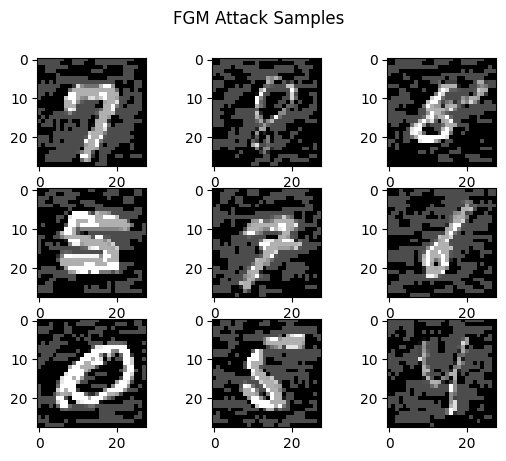

In [9]:
display_sample_images(artifacts["fgm_sample"], "FGM Attack Samples")

Even though we as humans can still mostly tell what numbers the above examples are supposed to be, the model we trained has significantly lower accuracy on them.

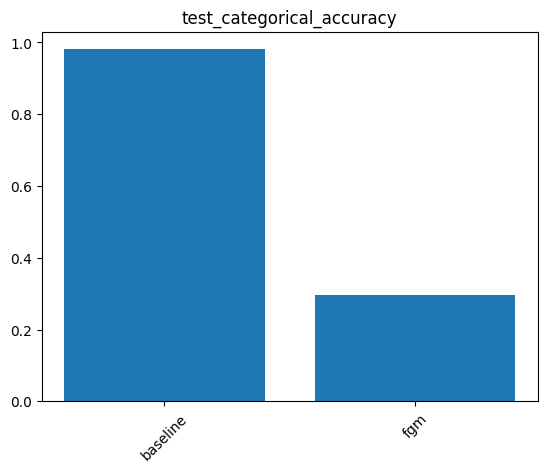

In [10]:
display_metrics(metrics, "test_categorical_accuracy")

### Generate patches based on the model and dataset

FGM is a very simple attack and not very practical. Next we will attempt an adversarial patch attack, which has more practical applications. We again are reusing the model artifact generated in the first step, and in this step we will just generate an adversarial patch.

In [11]:
jobs["patch_gen"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch generation",
    queue_id=queue_id,
    entrypoint_id=patch_gen_ep,
    values={ "dataset_name": "mnist" },
    artifact_values={ "model_artifact": artifacts["model"] },
    timeout=JOB_TIME_LIMIT,
)
jobs["patch_gen"] = wait_for_job(jobs["patch_gen"])
artifacts["patch"] = find_artifact_by_name("patch,", jobs["patch_gen"])
artifacts["patch_mask"] = find_artifact_by_name("patch_mask", jobs["patch_gen"])

'Job finished.'

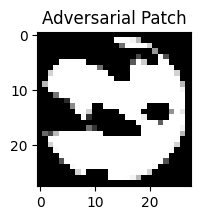

In [12]:
with TemporaryDirectory() as t:
    patch = np.load(client.artifacts.get_contents(artifacts["patch"]["id"], output_dir=t, file_stem="tmp.npy"))
    patch_mask = np.load(client.artifacts.get_contents(artifacts["patch_mask"]["id"], output_dir=t, file_stem="tmp.npy"))
plt.figure(figsize=(2, 2)) 
ax = plt.imshow(patch * patch_mask, cmap="gray")
ax = plt.title("Adversarial Patch")

### Generate adversarial examples by attaching generated patches to the testing data

Now that we have a patch, we would like to see how it affects the dataset's accuracy by applying that patch to all images in the test dataset. Using this entrypoint, we create an adversarial dataset, where each image has a patch applied to it at some location.

In [13]:
jobs["patch_apply"] = client.experiments.jobs.create(
    experiment_id=experiment_id,
    description=f"patch application",
    queue_id=queue_id,
    entrypoint_id=patch_apply_ep,
    values={ "dataset_name": "mnist" },
    artifact_values={
        "patch_artifact": artifacts["patch"],
        "model_artifact": artifacts["model"],
    },
    timeout=JOB_TIME_LIMIT,
)
jobs["patch_apply"] = wait_for_job(jobs["patch_apply"])
metrics["patch"] = get_metrics(jobs["patch_apply"])
artifacts["patch_data"] = find_artifact_by_name("adversarial_dataset,", jobs["patch_apply"])
artifacts["patch_data_sample"] = find_artifact_by_name("adversarial_dataset_sample", jobs["patch_apply"])

'Job finished.'

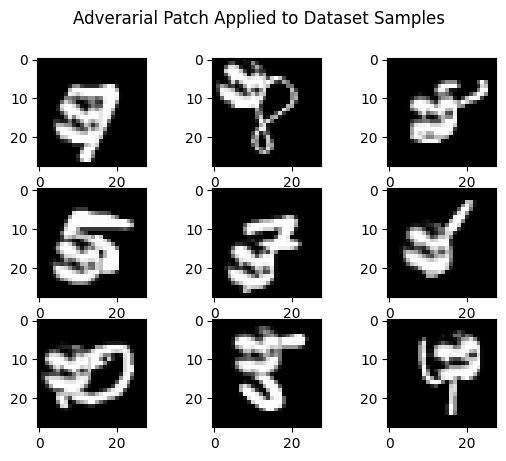

In [14]:
display_sample_images(artifacts["patch_data_sample"], "Adverarial Patch Applied to Dataset Samples")

The patch is a more significant of a change to these images to the human eye than the FGM attack was. Some of them may even be unrecognizable. However, the model has better accuracy against them than against FGM. Still, it performs worse than without the adversarial presence.

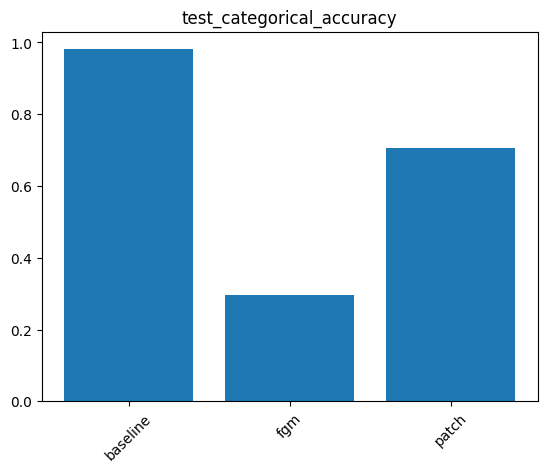

In [15]:
display_metrics(metrics, "test_categorical_accuracy")

### Preprocessing Defenses

Now that we've looked into two attacks that clearly affect the integrity of our model, we look at some mitigations. Preprocessing defenses are defenses which process the data at runtime before the data is predicted on by the model.
In this example, we look at three:

* Spatial Smoothing
* JPEG Compression
* Gaussian Augmentation

We evaluate these defenses against both the FGM and the Patch Attacks to see if they can improve the accuracy against those adversarial datasets at all.

In [16]:
def run_defense_job(data_artifact, model_artifact, defense_method):
    job = client.experiments.jobs.create(
        experiment_id=experiment_id,
        description=f"Apply spatial smoothing defense to FGM dataset.",
        queue_id=queue_id,
        entrypoint_id=defense_ep,
        values={ "defense_name": defense_method },
        artifact_values={
            "dataset_artifact": data_artifact,
            "model_artifact": model_artifact,
        },
        timeout=JOB_TIME_LIMIT,
    )
    return wait_for_job(job)

Running all combinations of attacks and defenses.

In [17]:
defenses = ["jpeg_compression", "gaussian_augmentation", "spatial_smoothing"]
attacks = ["fgm", "patch"]

for attack in attacks:
    for defense in defenses:
        attack_defense = f"{attack}_{defense}"
        jobs[attack_defense] = run_defense_job(artifacts[f"{attack}_data"], artifacts["model"], defense)
        metrics[attack_defense] = get_metrics(jobs[attack_defense])

'Job finished.'

Displaying samples downloaded from one of the runs. You can change attack and defense here to see the other ones.

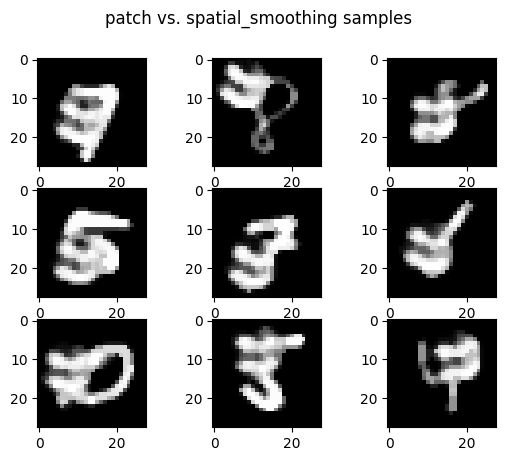

In [18]:
attack = "patch" # fgm, patch
defense = "spatial_smoothing" # jpeg_compression, gaussian_augmentation, spatial_smoothing
artifacts[f"{attack}_{defense}_sample"] = find_artifact_by_name("defended_dataset_sample", jobs[f"{attack}_{defense}"])
display_sample_images(artifacts[f"{attack}_{defense}_sample"], f"{attack} vs. {defense} samples")

We pull the metrics stored by each defense job and compare them with each other and the initial metrics against the unmodified dataset.

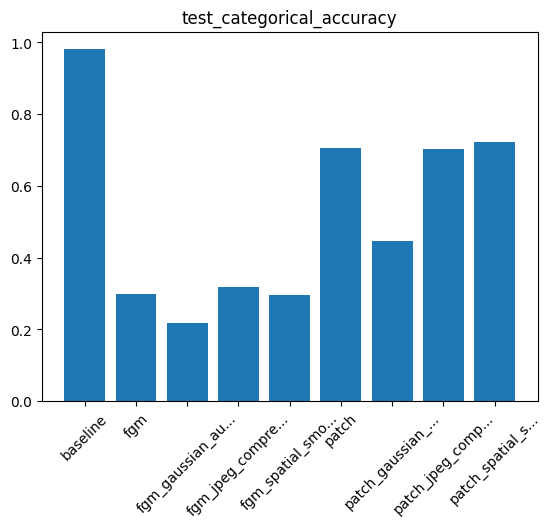

In [19]:
display_metrics(metrics, "test_categorical_accuracy")